# 10 Minutes to DeepGraph

This is a short introduction to DeepGraph. In the following, we demonstrate DeepGraph's core functionalities by a toy data-set, "flying balls".

First of all, we need to import some packages

In [213]:
%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import deepgraph as dg

**Loading Toy Data**

Then, we need a data-set in the form of a pandas `DataFrame <http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html>`_, representing the nodes of our graph

In [214]:
v = pd.read_pickle('./data/flying_balls.pickle')
print(v.head())

   time     x  y  ball_id
0     0  1692  0        0
1     0  8681  0        1
2     0   490  0        2
3     0  7439  0        3
4     0  4998  0        4


The data consists of

In [215]:
print(len(v))

1168


space-time measurements of 50 different toy balls in two-dimensional space. Each space-time measurement (i.e. row of `v`) represents a **node**.

Let's plot the data such that each ball has it's own color

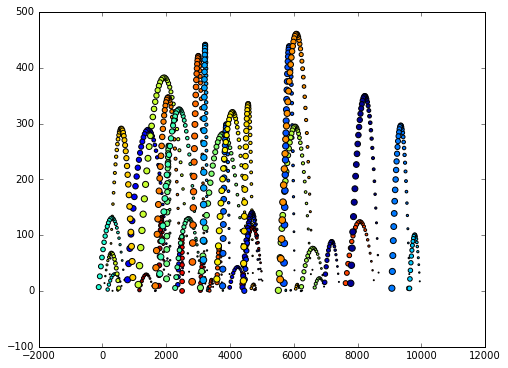

In [216]:
plt.scatter(v.x, v.y, s=v.time, c=v.ball_id)

## Creating Edges

In order to create edges between these nodes, we now initiate a :py:class:`dg.DeepGraph <.DeepGraph>` instance

In [217]:
g = dg.DeepGraph(v)
g

<DeepGraph object, with n=1168 node(s) and m=0 edge(s) at 0x7fdf2b2ed908>

and use it to create edges between the nodes given by :py:attr:`g.v <.DeepGraph.v>`. For that matter, we may define a **connector** function

In [218]:
def x_dist(x_s, x_t):
    dx = x_t - x_s
    return dx

and pass it to :py:meth:`g.create_edges <.create_edges>` in order to compute the distance in the x-coordinate of each pair of nodes

In [219]:
g.create_edges(connectors=x_dist)
g

<DeepGraph object, with n=1168 node(s) and m=681528 edge(s) at 0x7fdf2b2ed908>

In [220]:
print(g.e.head())

       dx
s t      
0 1  6989
  2 -1202
  3  5747
  4  3306
  5  2812


Let's say we're only interested in creating edges between nodes with a x-distance smaller than 1000. Then we may additionally define a **selector**

In [221]:
def x_dist_selector(dx, sources, targets):
    dxa = np.abs(dx)
    sources = sources[dxa <= 1000]
    targets = targets[dxa <= 1000]
    return sources, targets

and pass both the connector and selector to :py:meth:`g.create_edges <.create_edges>`

In [222]:
g.create_edges(connectors=x_dist, selectors=x_dist_selector)
g

<DeepGraph object, with n=1168 node(s) and m=156938 edge(s) at 0x7fdf2b2ed908>

In [223]:
print(g.e.head())

       dx
s t      
0 6   416
  7   848
  19 -973
  24  437
  38  778


There is, however, a much more efficient way of creating edges that involve a simple distance threshold such as the one above

## Creating Edges on a FastTrack

In order to efficiently create edges including a selection of edges via a simple distance threshold as above, one should use the :py:meth:`create_edges_ft method <.create_edges_ft>`. It relies on a sorted DataFrame, so we need to sort ``v`` first

In [224]:
g.v.sort_values('x', inplace=True)

In [225]:
g.create_edges_ft(ft_feature=('x', 1000))
g

<DeepGraph object, with n=1168 node(s) and m=156938 edge(s) at 0x7fdf2b2ed908>

Let's compare the efficiency

In [226]:
%timeit -n3 -r3 g.create_edges(connectors=x_dist, selectors=x_dist_selector)

3 loops, best of 3: 599 ms per loop


In [227]:
%timeit -n3 -r3 g.create_edges_ft(ft_feature=('x', 1000))

3 loops, best of 3: 178 ms per loop


The :py:meth:`create_edges_ft method <.create_edges_ft>` also accepts connectors and selectors as input. Let's connect only those measurements that are close in space and time 

In [228]:
def y_dist(y_s, y_t):
    dy = y_t - y_s
    return dy

def time_dist(time_t, time_s):
    dt = time_t - time_s
    return dt

def y_dist_selector(dy, sources, targets):
    dya = np.abs(dy)
    sources = sources[dya <= 100]
    targets = targets[dya <= 100]
    return sources, targets

def time_dist_selector(dt, sources, targets):
    dta = np.abs(dt)
    sources = sources[dta <= 1]
    targets = targets[dta <= 1]
    return sources, targets

In [229]:
g.create_edges_ft(ft_feature=('x', 100),
                  connectors=[y_dist, time_dist],
                  selectors=[y_dist_selector, time_dist_selector])
g

<DeepGraph object, with n=1168 node(s) and m=1899 edge(s) at 0x7fdf2b2ed908>

In [230]:
print(g.e.head())

         dt         dy       ft_r
s   t                            
890 867  -1  19.311136  33.415831
867 843  -1  17.678482  33.415831
843 818  -1  16.045829  33.415831
818 792  -1  14.413176  33.415831
792 766  -1  12.780523  33.415831


We can now plot the flying balls and the edges we just created with the :py:meth:`plot_2d method <.plot_2d>`

(1000, 3000)

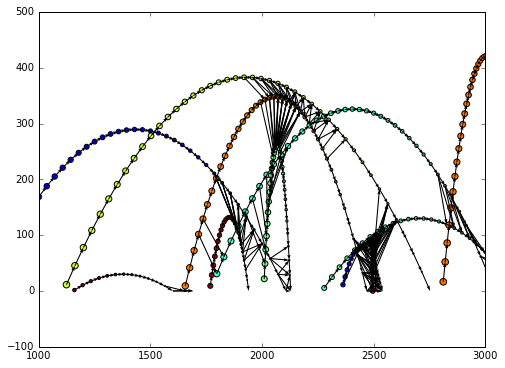

In [250]:
g.plot_2d('x', 'y', edges=True, kwds_scatter={'c': g.v.ball_id, 's': g.v.time})
plt.xlim(1000,3000)

## Graph Partitioning

The :py:class:`DeepGraph class <.DeepGraph>` also offers methods to partition :py:meth:`nodes <.partition_nodes>`, :py:meth:`edges <.partition_edges>` and an :py:meth:`entire graph <.partition_graph>`. See the docstrings for details and examples.

## Graph Interfaces

Furthermore, you may inspect the docstrings of :py:meth:`return_cs_graph <.return_cs_graph>`, :py:meth:`return_nx_graph <.return_nx_graph>` and :py:meth:`return_gt_graph <.return_gt_graph>` to see how to convert from DeepGraph's DataFrame representation of a network to sparse adjacency matrices, NetworkX's network representation and graph_tool's network representation.

## Plotting Methods

DeepGraph also offers a number of useful Plotting methods. See :ref:`plotting methods <plotting_methods>` for details and inspect the corresponding docstrings for examples.